In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# # filter only test playersex
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = 100

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

100

In [25]:
df.head()

,playerId,target1,target2,target3,target4,date,home,positionName,pstatsDate,battingOrder,...,weekday,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaN,NaT,NaN,...,0,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaN,NaT,NaN,...,1,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaN,NaT,NaN,...,2,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaN,NaT,NaN,...,3,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaN,NaT,NaN,...,4,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661


In [26]:
from sklearn.preprocessing import QuantileTransformer

### preprocessing with pipelines

In [27]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN, PdStandardNorm
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info
from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [28]:
inplace_ffill_features = ['numberOfFollowers',
                          'teamFollowers',
                          'status',
                          'teamId',
                          'rosterDate',
                          'pstatsDate']

In [29]:
# transformer for filling nan values with past valid values
# transformer for generating some hardcoded features
inplace_fill_forward_tmf = FunctionTransformer(forward_fill,
                                               kw_args={'features': inplace_ffill_features,
                                                        'on': ['playerId', 'year']})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [30]:
# creating pipeline
ffill_and_gen_harcoded_feat = Pipeline([('inplace_fill_forward', inplace_fill_forward_tmf),
                                        ('hardcoded_feat', harcoded_feat_tmf)])

In [31]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [32]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName',
              'status', 'teamId', 'weekday',
              'opponentTeamId', 'birthCountry']

In [33]:
categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [ ]:
# for the statistics, we will compute them and then resuse them
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[30], drop_index=False)
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])
target_stats_table = target_stats_tmf.fit_transform(df)


target_stats_table.head()

In [ ]:
## merge computed statistics
reuse_computed_stats = Pipeline([('merge_stats', FeaturesTable(target_stats_table, lags=[45], clip_max=True)),
                                 ('fillnan', FunctionTransformer(fillna)),
                                 ('normalize', PdScaleNorm())
                                ])

In [ ]:
# for continuous features, we will filter them and then fill nan values and normalize them

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=categories +
                                                                           pp_cols +
                                                                           ['target_avg'])),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdStandardNorm()),
                               ])

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
df.columns.to_list()

In [ ]:
from pipeline.core import FilterFeatures

In [ ]:
player_tv_cont_features = FilterFeatures(['runsScored', 'homeRuns',
                                          'hits', 'SLG',
                                          'rbi',
                                          'plateAppearances',
                                          'runsPitching',
                                          'playerId', 'date']).fit(df)._features

In [ ]:
player_tv_cont_features

In [ ]:
## moving stats for players stats
# get the rest of the continuous features
stats_gen_cont_features = StatisticGen(stats=['sum', 'max'],
                             windows=[7],
                             drop_index=True)
_mov_cont_feat_tmf = Pipeline([('fillnan', FunctionTransformer(fillna)),
                               ('cont_stats', stats_gen_cont_features),
                                ('normalize', PdStandardNorm()),
                                ])
mov_cont_feat_tmf = PdColumnTransformer([('cont', _mov_cont_feat_tmf, player_tv_cont_features)]
                                 )

In [ ]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([('stats', reuse_computed_stats), 
                                   ('cont_feat', continuous_feat_tmf), 
                                   ('cats', categories_tmf),
                                   ('mov_feat', mov_cont_feat_tmf),
                                  ])

In [61]:
# main pipeline with all steps 
pipeline = Pipeline([('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [62]:
pipeline

Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7f7b98bae1f0>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate'],
                                                               'on': ['playerId',
                                                                      'year']})),
                                 ('hardcoded_feat',
                                  FunctionTrans

### modeling 

In [63]:
from omegaconf import OmegaConf
hp = {'epochs': 10,
      'batch_size': 512,
      'max_emb_sz': 20,
      'encoder_dim': 512,
      'depth': 2,
      'emb_dropout': 0.5,
      'feature_reduction_dim': 32,
      'dropout': 0.2,
      'decrease_factor': 0.5,
      'drop_decrease_factor': 1.,
      'lr': 0.001,
      'wd': 3e-5,
      'scale_output': True}

In [64]:
from train.cont_emb_stack import run_emb_model_fn
from evaluate.metrics import compute_metrics

In [65]:
def filter_by_idx(df, idx):
    return df.loc[idx, :].reset_index(drop=True)

In [ ]:
test_dates = ['2021-04-01', '2021-05-01',
              '2021-06-01', '2021-07-01',
              '2021-08-01']
output = []

cv_prediction = []
for start_test_date, end_test_date in zip(test_dates[:-1], test_dates[1:]):
    train_idx = df['date'] < start_test_date
    valid_idx = df['date'].between(start_test_date, end_test_date, inclusive=False)
    
    print(f'evaluating from {start_test_date} to {end_test_date}')
    
    print('training pipeline')
    pipeline.fit(filter_by_idx(df, train_idx))
    print('executing pipeline')
    features = pipeline.transform(df)
    cont_features = features.columns.drop(categories).to_list()
    
    
    train_data = filter_by_idx(features, train_idx)
    valid_data = filter_by_idx(features, valid_idx)
    
    # add the target to features ds
    train_data[target_cols + ['date']] = df.loc[train_idx, target_cols + ['date']].to_numpy()
    valid_data[target_cols + ['date']] = df.loc[valid_idx, target_cols + ['date']].to_numpy()
    
    config_hp = {'hp': hp,
                 'seed': 2021,
                 'features': cont_features,
                 'categories': categories,
                 'target_cols': target_cols}
    config_hp = OmegaConf.create(config_hp)
    fold_output = run_emb_model_fn(config_hp, train_data, valid_data)
    
    _prediction = fold_output.prediction[:]

    fold_prediction = pd.DataFrame(_prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])
    
    fold_prediction[pp_cols] = df.loc[valid_idx, pp_cols].to_numpy()
    output.append(fold_output)
    cv_prediction.append(fold_prediction)
    print('score')
    print(compute_metrics(fold_prediction))

cv_prediction = pd.concat(cv_prediction, axis=0, ignore_index=True)

evaluating from 2021-04-01 to 2021-05-01
training pipeline
executing pipeline


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type           | Params
------------------------------------------------
0 | emb          | EmbeddingLayer | 24.4 K
1 | output_layer | Sequential     | 224 K 
------------------------------------------------
248 K     Trainable params
0         Non-trainable params
248 K     Total params
0.996     Total estimated model params size (MB)


RegressionEmbModel(
  (emb): EmbeddingLayer(
    (dropout): Dropout(p=0.5, inplace=False)
    (emb): ModuleDict(
      (playerId): Embedding(1187, 20)
      (seasonPart): Embedding(7, 3)
      (year): Embedding(4, 2)
      (primaryPositionName): Embedding(9, 3)
      (status): Embedding(14, 4)
      (teamId): Embedding(31, 6)
      (weekday): Embedding(7, 3)
      (opponentTeamId): Embedding(33, 6)
      (birthCountry): Embedding(23, 5)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=179, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


Validation sanity check: 0it [00:00, ?it/s]

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/core/step_result.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

loading model to best score
best score = 1.5173468589782715


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:895: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')
Exception ignored in: <function _releaseLock at 0x7f7bd42c6430>
Traceback (most recent call last):
  File "/home/med/anaconda3/envs/mlb/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7f7bd42c6430>
Traceback (most recent call last):
  File "/home/med/anaconda3/envs/mlb/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [47]:
# from train.core import Ensemble, predict_recursive
# ensemble = Ensemble([output], pipeline)

In [48]:
# %%time
# raw_train_fr = raw_train_df[df.columns].copy()

# recursive_prediction = []
# for date, val_date_df in raw_valid_df.groupby('date'):
#     val_date_df = val_date_df[df.columns].reset_index(drop=True)
#     _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
#                                                      raw_train_fr,
#                                                      ensemble,
#                                                      n_days=90 + 60 + 10,
#                                                      target_cols=target_cols)
#     recursive_prediction.append(_recurive_pred)

# recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
# recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
# recursive_prediction.reset_index(drop=True, inplace=True)
# recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
#                                      for f in target_cols}, inplace=True)
# recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

In [49]:
# last_mean_prediction = (raw_valid_df.set_index('date').groupby(['playerId'])[target_cols]
#                         .rolling(window=7, min_periods=1).mean().reset_index())
# last_mean_prediction

# hardest_ids = [660271]
# hardest_idx = raw_valid_df['playerId'].isin(hardest_ids)

# yhat_cols = ['yhat1', 'yhat2', 'yhat3', 'yhat4']
# valid_test_prediction_with_last_mean = valid_test_prediction.copy(deep=True)
# valid_test_prediction_with_last_mean.loc[hardest_idx, yhat_cols] = last_mean_prediction.loc[hardest_idx, target_cols].to_numpy()

# valid_test_prediction_with_last_mean

In [50]:
# valid_test_prediction.loc[hardest_idx].head()

In [51]:
# valid_test_prediction_with_last_mean.loc[hardest_idx].head()

In [52]:
# raw_cv_prediction = cv_prediction.copy(deep=True)

In [53]:
cv_prediction = filter_by_id(cv_prediction, player_in_test)

In [54]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(cv_prediction)

{'mae_mean': 1.2874374003275966,
 'mae_1': 1.043597537773869,
 'mae_2': 1.9814590261391802,
 'mae_3': 0.8220596308021311,
 'mae_4': 1.3026334065952059}

In [64]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(valid_test_prediction_with_last_mean)

In [65]:
(cv_prediction.groupby(cv_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
4,1.495700,1.159734,2.327031,0.907535,1.588502
5,1.341877,1.080413,2.230109,0.844206,1.212779
6,1.252320,0.982088,1.763485,0.791138,1.472568
7,0.871538,0.875557,1.283970,0.681657,0.644966


In [66]:
# (valid_test_prediction_with_last_mean.groupby(valid_test_prediction.date.dt.month)
#  .apply(lambda x: pd.Series(compute_metrics(x))))

In [67]:
# (april_set_with_last_mean.groupby(['playerId'])
#  .apply(lambda x: pd.Series(compute_metrics(x)))
#  .sort_values(by='mae_mean', ascending=False))

In [68]:
(cv_prediction.groupby(['playerId'])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,32.262157,20.821755,33.788532,34.982818,39.455522
594798,20.054847,10.650849,28.323865,17.900224,23.344450
665487,16.718806,14.743250,12.590406,19.335242,20.206325
665489,14.614228,17.506258,17.018897,11.699967,12.231788
405395,13.589985,8.501391,13.012227,10.003544,22.842781
...,...,...,...,...,...
665600,0.041419,0.000340,0.128389,0.001440,0.035507
665759,0.040498,0.000188,0.125377,0.000204,0.036221
683232,0.036027,0.000145,0.088947,0.002539,0.052477


In [69]:
hardest_id = filter_by_id(cv_prediction, [660271])

In [70]:
(hardest_id.groupby(['playerId', hardest_id.date.dt.month])
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False))

mae_mean      mae_1      mae_2      mae_3      mae_4
playerId date                                                       
660271   7     43.080986  31.733505  27.546360  48.678783  64.365297
         6     36.086216  20.991663  37.940147  39.840230  45.572823
         5     29.031026  19.905821  37.619328  30.344405  28.254549
         4     25.811637  15.579089  29.117980  27.367370  31.182110

In [71]:
# # metrics from 2021-03-01 up to 2021-04-30
# compute_metrics(recursive_prediction)

In [72]:
# # metrics from 2021-03-01 up to 2021-03-31
# compute_metrics(valid_rc_prediction)

In [73]:
# # metrics from 2021-04-01 up to 2021-04-30
# compute_metrics(test_rc_prediction)

In [74]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

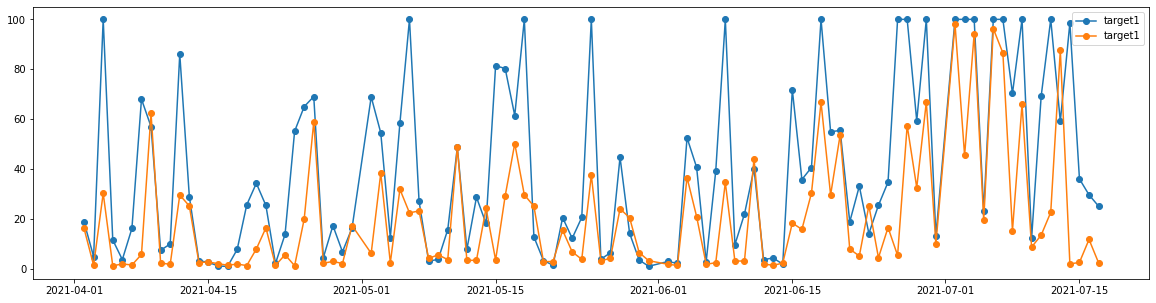

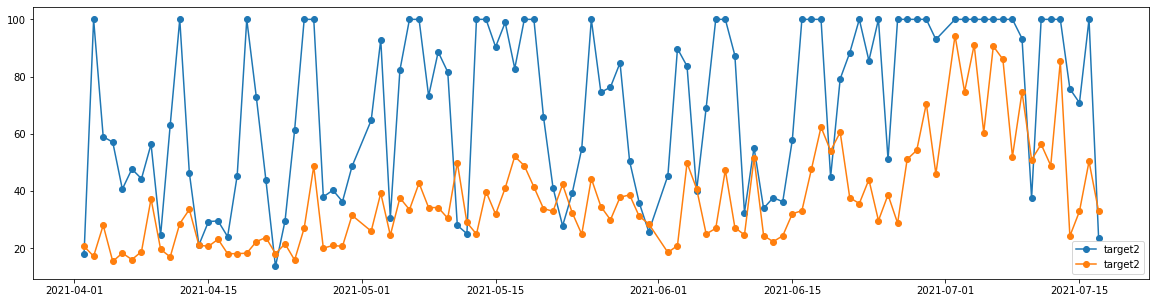

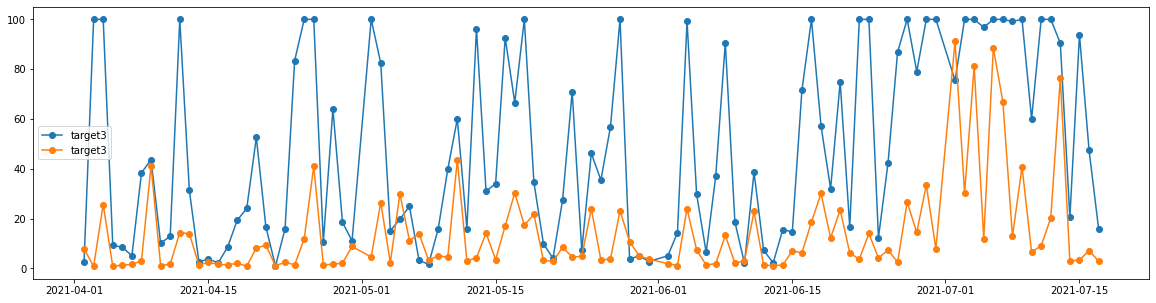

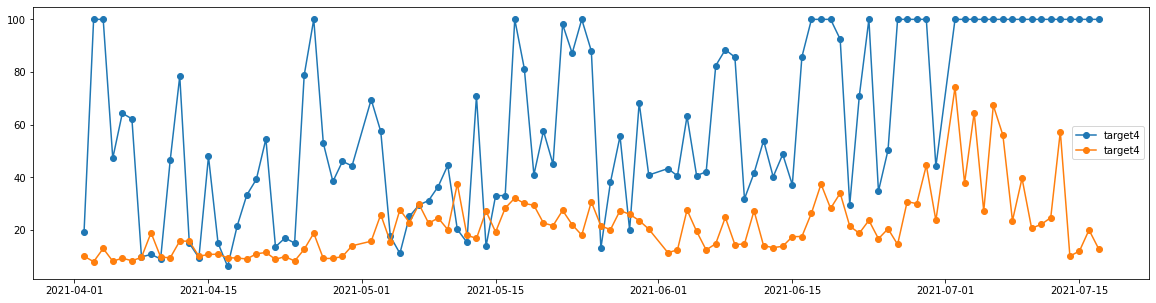

In [75]:
for index in range(1, 5):
    plot_pred(hardest_id, playerId=660271, index=index)

In [ ]:
import numpy as np
import pandas as pd


def permutation_importance(predict_fn, data,
                           features,
                           target,
                           score_func,
                           times: int = 1):

    def _score(data):
        _prediction = predict_fn(data)
        prediction = data[target].copy()
        prediction[['yhat1', 'yhat2', 'yhat3', 'yhat4']] = _prediction
        error = score_func(prediction)
        return error['mae_mean']

    base_score = _score(data)
    fi = []

    for feature in features:
        permuted_data = data.copy()
        permuted_data[feature] = np.random.permutation(permuted_data[feature])
        feature_score = _score(permuted_data)
        feature_importance = {'feature': feature,
                              'score': feature_score,
                              'importance': feature_score-base_score,
                              }
        fi.append(feature_importance)
    fi = pd.DataFrame(fi)
    fi['importance'] *= 100
    fi.sort_values(by='importance', inplace=True, ascending=False)
    fi.reset_index(drop=True, inplace=True)
    return fi

In [ ]:
fi_data = valid_data

In [ ]:
fi_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [ ]:
all_features_list = list(features.columns)

In [ ]:
%%time
fi_reg = permutation_importance(output.predict_fn, valid_data, 
                                all_features_list, target=target_cols, 
                                score_func=compute_metrics,
                                times=5)

In [ ]:
fi_reg

In [ ]:
valid_data['raw_playerId'] = raw_valid_df['playerId']

In [ ]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)

In [ ]:
output_path = 'prediction/drop_lstm'
os.makedirs(output_path, exist_ok=True)

In [ ]:
# valid_test_prediction.to_csv(os.path.join(output_path, 'april_to_jul.csv'), index=False)